In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


path = r'./dataset_v2'

# We use pyarrow to load data efficiently (recommended in Kaggle)
df_train = pd.read_parquet(f'{path}/train.parq', engine='pyarrow')
df_test = pd.read_parquet(f'{path}/test.parq', engine='pyarrow')
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61629685 entries, 0 to 61629684
Data columns (total 11 columns):
 #   Column             Dtype              
---  ------             -----              
 0   attack_time        datetime64[us, UTC]
 1   watcher_country    category           
 2   watcher_as_num     float32            
 3   watcher_as_name    category           
 4   attacker_country   category           
 5   attacker_as_num    float32            
 6   attacker_as_name   category           
 7   attack_type        category           
 8   watcher_uuid_enum  int32              
 9   attacker_ip_enum   int32              
 10  label              int8               
dtypes: category(5), datetime64[us, UTC](1), float32(2), int32(2), int8(1)
memory usage: 2.0 GB


In [2]:
# ====== REVIEW DATA ======

# Review dataset:

print("This is the shape of the train dataset:")
print(df_train.shape)
print("This is the shape of the test dataset:")
print(df_test.shape)

This is the shape of the train dataset:
(61629685, 11)
This is the shape of the test dataset:
(18682297, 10)


In [3]:
# Check for missing values, print their percentage per feature and types

missing_counts = df_train.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
print("Columns with missing values:\n", missing_counts)

missing_percent = df_train.isnull().mean() * 100
missing_report = missing_percent[missing_percent > 0]

print("Missing values (in %):")
print(missing_report)

cols_with_na = missing_counts[missing_counts > 0].index

print("Columns with missing values and their data types:")
for col in cols_with_na:
    print(f"{col:<25} | Dtype: {df_train[col].dtype}")


Columns with missing values:
 watcher_country     349386
watcher_as_name     349405
attacker_country     73661
attacker_as_num        462
attacker_as_name     49512
dtype: int64


Missing values (in %):
watcher_country     0.566912
watcher_as_name     0.566943
attacker_country    0.119522
attacker_as_num     0.000750
attacker_as_name    0.080338
dtype: float64
Columns with missing values and their data types:
watcher_country           | Dtype: category
watcher_as_name           | Dtype: category
attacker_country          | Dtype: category
attacker_as_num           | Dtype: float32
attacker_as_name          | Dtype: category


Total IPs: 148259
Min events for a single IP: 1
Max events for a single IP: 1466169
Average events per IP: 415.6893342056806
Median events for a single IP: 37.0
95th percentile: 723.1000000000058


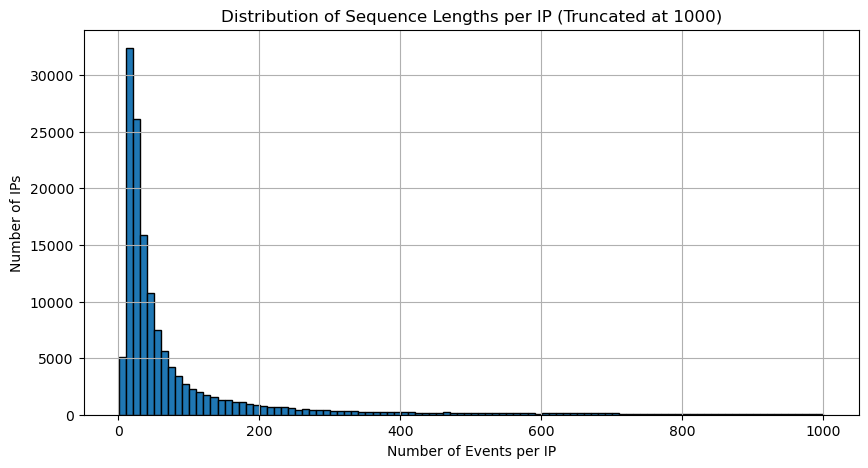

In [4]:
# Check the number of events per attacker IP
sequence_lengths = df_train['attacker_ip_enum'].value_counts()

# Summary statistics
print("Total IPs:", len(sequence_lengths))
print("Min events for a single IP:", sequence_lengths.min())
print("Max events for a single IP:", sequence_lengths.max()) # we learn the max is close to 1.5M events for 1 IP
print("Average events per IP:", sequence_lengths.mean())
print("Median events for a single IP:", sequence_lengths.median())
print("95th percentile:", sequence_lengths.quantile(0.95))

plt.figure(figsize=(10, 5))
plt.hist(sequence_lengths, bins=100, range=(1, 1000), edgecolor='black') #truncate to make data legible
plt.title("Distribution of Sequence Lengths per IP (Truncated at 1000)") 
plt.xlabel("Number of Events per IP")
plt.ylabel("Number of IPs")
plt.grid(True)
plt.show()

# The graph helps find outliers so that we can deal with them before running the model (and using too much computation)


In [5]:
# Check that no IP is labeled as both VPN and non-VPN in the dataset

# Group by attacker IP and count unique labels
label_counts = df_train.groupby('attacker_ip_enum')['label'].nunique()

# Find any IPs that have more than 1 unique label
inconsistent_ips = label_counts[label_counts > 1]

print(f"Number of inconsistent IPs: {len(inconsistent_ips)}")


Number of inconsistent IPs: 0


In [6]:
# Check how many VPNs (label=1)
vpn_counts = df_train.groupby('attacker_ip_enum')['label'].first().value_counts()
vpn_ratio = df_train.groupby('attacker_ip_enum')['label'].first().value_counts(normalize=True)
print("Counts:")
print(vpn_counts)

print("Ratios (%):")
print(vpn_ratio)

# We find that 2% of data is VPN - highly unbalanced

Counts:
label
0    145369
1      2890
Name: count, dtype: int64
Ratios (%):
label
0    0.980507
1    0.019493
Name: proportion, dtype: float64



Count of unique attacker countries per IP (split by VPN label):
label                          0     1
attacker_country_nunique              
0                             60     6
1                         145155  2877
2                            154     7


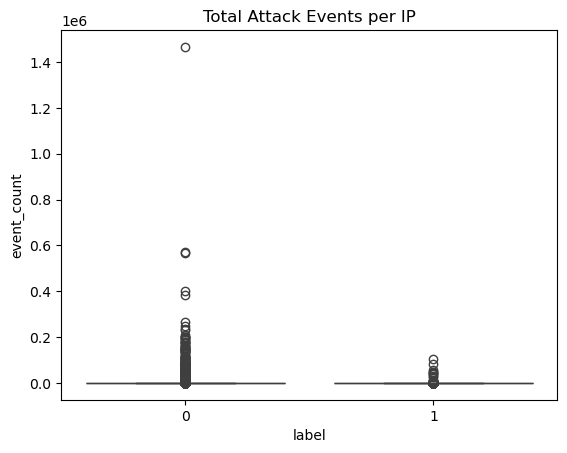

In [7]:
# Aggregate per IP
ip_summary = df_train.groupby('attacker_ip_enum').agg({
    'attack_time': 'count',
    'attacker_country': pd.Series.nunique,
    'label': 'first'
}).rename(columns={
    'attack_time': 'event_count',
    'attacker_country': 'attacker_country_nunique'
})

# Print summary
print("\nCount of unique attacker countries per IP (split by VPN label):")
country_summary = ip_summary.groupby(['label', 'attacker_country_nunique']).size().unstack(fill_value=0)
print(country_summary.T.sort_index())

# Boxplot: total events per IP
sns.boxplot(x='label', y='event_count', data=ip_summary)
plt.title("Total Attack Events per IP")
plt.show()

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import OrdinalEncoder
import os
import random

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
# ====== REPRODUCIBILITY SETUP ======
# So we can fix the seed during research & debugging but 
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
# ====== TUNABLE HYPERPARAMETERS ======
HYPERPARAMS = {
    "train_fraction": 1, # 1 = the whole dataset
    "min_seq_len": 3, # events per attacker
    "embedding_dim": 8,
    "hidden_dim": 32,
    "batch_size": 16,
    "epochs": 4,
    "learning_rate": 1e-3,
    "max_seq_len": 100
}

In [11]:
# ====== DATASET ======

# We show paths again for clarity - keep in case accidental changes were made during exploration
path = r"./dataset_v2"
train_file = os.path.join(path, "train.parq")

# Load data
df_train = pd.read_parquet(train_file, engine="pyarrow")
print("Train shape:", df_train.shape)

# Sample IPs for prototyping
train_fraction = HYPERPARAMS["train_fraction"]
rng = np.random.default_rng(SEED)
sample_train_ips = rng.choice(df_train["attacker_ip_enum"].unique(), int(len(df_train["attacker_ip_enum"].unique()) * train_fraction), replace=False)
df_train = df_train[df_train["attacker_ip_enum"].isin(sample_train_ips)].copy()
print("After sampling:", df_train.shape)

Train shape: (61629685, 11)


After sampling: (61629685, 11)


In [12]:
# ====== FEATURE ENGINEERING ======

# Time processing: convert attack_time (a timestamp) into something useful for RNN/GRU
df_train["attack_time"] = pd.to_datetime(df_train["attack_time"]) # ensure attack_time is in datetime format
df_train.sort_values(by=["attacker_ip_enum", "attack_time"], inplace=True) # sort values in chronological order
df_train["time_delta"] = df_train.groupby("attacker_ip_enum")["attack_time"].diff().dt.total_seconds().fillna(0) # add new feature

# time_delta: number in seconds since the previous attack for the same attacker

In [13]:
# Feature processing

# Convert "attacker_as_num", "watcher_as_num" and "watcher_uuid_enum" from numerical type into cateogry type (since these represent a name, not contiguous number)
# Replace missing values with "Uknown" instead of dropping since the missing information could mean something
# Set features into numerical and categorical columns
# ====== FEATURE CATEGORIZATION ======
categorical_cols = [
    "watcher_country", "watcher_as_name", "watcher_as_num", "watcher_uuid_enum",
    "attacker_country", "attacker_as_name", "attacker_as_num", "attack_type"
]
numeric_cols = ["time_delta"]

# ====== CATEGORICAL FIX & MISSING VALUE HANDLING ======

# Convert ID-like numeric fields to strings so they can be treated as categories
for col in ["attacker_as_num", "watcher_as_num", "watcher_uuid_enum"]:
    df_train[col] = df_train[col].astype(str)

# Fill missing values AFTER setting category type
for col in categorical_cols:
    df_train[col] = df_train[col].astype("category")  # convert to category FIRST
    if "Unknown" not in df_train[col].cat.categories:
        df_train[col] = df_train[col].cat.add_categories(["Unknown"])  # add "Unknown" category
    df_train[col] = df_train[col].fillna("Unknown")  # then fill missing values with "Unknown"


In [14]:
# ====== ENCODING ======
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1) # this makes sure when padding, -1 means padding
df_train[categorical_cols] = encoder.fit_transform(df_train[categorical_cols]) + 1 # real categories start from 1 (unseen values will be encoded as -1 + 1 = 0 for padding later)

In [15]:
# Sequence builder

# Creates time-ordered sequences of attack events for each attacker IP
# Each sequence is a list of features (categorical and numerical) and each is labeled as VPN or not (based on labeled data)


def build_sequences(df, feature_cols, min_len):
    seqs, labs = [], []
    for ip, group in df.groupby("attacker_ip_enum"):
        if len(group) >= min_len:
            arr = group[feature_cols].to_numpy(dtype=np.float32)
            label = group["label"].iloc[0]
            seqs.append(arr)
            labs.append(label)
    return seqs, labs

feature_cols = categorical_cols + numeric_cols
full_seqs, full_labels = build_sequences(df_train, feature_cols, HYPERPARAMS["min_seq_len"])
full_seqs = np.array(full_seqs, dtype=object)
full_labels = np.array(full_labels, dtype=np.int64)

# ASSUMPTIONS: assume a minimum number of events (min_seq_len) per attacker IPs to be useful data. 

In [16]:
# ====== SPLIT TRAIN/VAL/TEST ======

# Split into train/val/test
X_trainval, X_test, y_trainval, y_test = train_test_split(full_seqs, full_labels, test_size=0.2, stratify=full_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

# Because test dataset does not have labels, use split the train set
# Equivalent to: 80% trainval (64% train ,16% val), 20% test

for name, labels in zip(["Full Sample", "Train", "Val", "Test"], [full_labels, y_train, y_val, y_test]):
    total = len(labels)
    counts = np.bincount(labels)
    percentages = counts / total * 100
    print(f"{name} distribution:")
    for i, (count, pct) in enumerate(zip(counts, percentages)):
        print(f"  Label {i}: {count} ({pct:.2f}%)")

# ASSUMPTIONS: because the test dataset did not include labels, we split the train dataset        

Train: 94496 Val: 23625 Test: 29531
Full Sample distribution:
  Label 0: 144776 (98.05%)
  Label 1: 2876 (1.95%)
Train distribution:
  Label 0: 92655 (98.05%)
  Label 1: 1841 (1.95%)
Val distribution:
  Label 0: 23165 (98.05%)
  Label 1: 460 (1.95%)
Test distribution:
  Label 0: 28956 (98.05%)
  Label 1: 575 (1.95%)


In [17]:
# ====== PADDING ====== 

# Dataset & Collate
# Note: each sequence is a full list of events for one IP address. Exmaple, seq1= [IP1: event1 → event2 → event3], seq2= [IP2: event1 → event2 → event3 → event4 → event5]
# Sorts by sequence -> After sorting: [IP2, IP1], then pads the features based on longest sequence
def collate_fn_packed(batch):
    sequences, labels = zip(*batch)
    # Truncate sequences if they exceed max_seq_len
    if HYPERPARAMS.get("max_seq_len"):
        sequences = [s[-HYPERPARAMS["max_seq_len"]:] for s in sequences]
        
    seq_tensors = [torch.tensor(s, dtype=torch.float32) for s in sequences]
    labels_t = torch.tensor(labels, dtype=torch.float32)
    lengths = [len(s) for s in seq_tensors] # calculate length of each sequence (by # of events per attacker IP)
    sorted_idx = np.argsort(lengths)[::-1].copy()
    seq_tensors_sorted = [seq_tensors[i] for i in sorted_idx] # sort in order for pack_padded_sequence [longest_seq ... , shortest_seq]
    labels_sorted = labels_t[sorted_idx]
    lengths_sorted = [lengths[i] for i in sorted_idx]

    # separate cols that are categorical with last numerical
    cat_tensors, num_tensors = [], []
    for st in seq_tensors_sorted:
        cat_tensors.append(st[:, :-1].long())
        num_tensors.append(st[:, -1:].float())

    # pads both categorical and numeric sequences to match longest sequence in the batch. Gives the padding value 0
    cat_padded = pad_sequence(cat_tensors, batch_first=True, padding_value=0) # padded categorical features
    num_padded = pad_sequence(num_tensors, batch_first=True, padding_value=0) # padded numerical features

    return cat_padded, num_padded, labels_sorted, lengths_sorted

# Wraps the list of sequences (that has variable length) so Pytorch can treat it like a regular datatset
class IPSequenceDataset(Dataset):
    def __init__(self, sequences, labels): # list of array, one per attacker IP
        self.sequences = sequences # list of labels (0 0r 1) per attacker IP
        self.labels = labels
    def __len__(self):
        return len(self.sequences) # No. of  sequences 
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx] # returns one sequence-label pair

In [18]:
# ====== MODEL & EMBBEDINGS ======

# Check embedding_dim for full Dataset
for col in categorical_cols:
    print(f"{col}: {df_train[col].nunique()} unique values")

# watcher_country: 131 unique values -> 8 dim
# watcher_as_name: 2771 unique values -> 16 dim
# watcher_as_num: 2914 unique values -> 16 dim
# watcher_uuid_enum: 75277 unique values -> 32 dim
# attacker_country: 215 unique values -> 8 dim
# attacker_as_name: 8024 unique values -> 32 dim
# attacker_as_num: 8398 unique values -> 32 dim
# attack_type: 15 unique values -> 4 dim

# Custom embedding dimensions for each categorical feature based on full dataset. 
# Adjust if preferred.
embedding_dims = [4, 8, 8, 16, 4, 16, 16, 2]  # watcher_country, watcher_as_name, ..., attack_type

# Model with per-column embeddings (more efficient than one-hot encoding)
class VPNClassifierGRUPacked(nn.Module):
    def __init__(self, vocab_sizes, embedding_dims, numeric_dim=1, hidden_dim=64):
        super().__init__()

        # create a separate embedding layer for each categorical column
        self.embedding_layers = nn.ModuleDict({
            str(i): nn.Embedding(vocab_sizes[i] + 2, embedding_dims[i], padding_idx=0) # padding_idx = 0 ensures padding tokens always map to a zero vector
            for i in range(len(vocab_sizes))
        })

        total_embed_dim = sum(embedding_dims) # calculate total size of concatenated embedding across all columns
        self.gru = nn.GRU(total_embed_dim + numeric_dim, hidden_dim, batch_first=True) # GRU takes input: [emebedding + numeric] per timestep
        self.fc = nn.Linear(hidden_dim, 1) # final layer to produce 1 "logit" per sequence (raw data)
 
    def forward(self, cat_padded, num_padded, lengths): # apply embeddings to each categorical column independently
        embedded = [self.embedding_layers[str(i)](cat_padded[:, :, i]) for i in range(cat_padded.shape[2])]
        x_cat = torch.cat(embedded, dim=-1) # Concatenate all categorical embeddings: shape [batch, seq_len, total_embed_dim]
        x_full = torch.cat([x_cat, num_padded], dim=-1) # Concatenate numeric feature (time_delta): shape [batch, seq_len, total_embed_dim + numeric_dim]
        packed_input = pack_padded_sequence(x_full.contiguous(), lengths=lengths, batch_first=True, enforce_sorted=False) # convert padded sequence into a packed format for efficient RNN processing
        packed_output, hidden = self.gru(packed_input) 
        logits = self.fc(hidden[-1]) # final hidden state (many to one), shape: [batch, 1]
        return logits.squeeze(1)

watcher_country: 131 unique values


watcher_as_name: 2771 unique values


watcher_as_num: 2914 unique values


watcher_uuid_enum: 75277 unique values


attacker_country: 215 unique values


attacker_as_name: 8024 unique values


attacker_as_num: 8398 unique values


attack_type: 15 unique values


In [19]:
# Prepare data loaders
vocab_sizes = [int(df_train[col].max()) for col in categorical_cols] # get vocabulary size for each categorical column (used for embedding layers)
batch_size = HYPERPARAMS["batch_size"]

# Load train/val/test datasets into PyTorch dataset wrappers
train_dataset = IPSequenceDataset(X_train, y_train)
val_dataset = IPSequenceDataset(X_val, y_val)
test_dataset = IPSequenceDataset(X_test, y_test)

# Prepare data loaders for training, validation and testing

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_packed) # shuffle=True for training to make sure the data is randomized each epoch
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_packed)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_packed)

In [20]:
# Initialize model

# create GRU-based model
model = VPNClassifierGRUPacked(
    vocab_sizes=vocab_sizes, # unique values in each categorical feature
    numeric_dim=1, # only using time_delta
    embedding_dims=embedding_dims, # size of embedding vectors per categorical feature
    hidden_dim=HYPERPARAMS["hidden_dim"] # number of hidden units
).to(device) # moves to GPU if available, else CPU

# calculate class imbalance ratio
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
imbalance_ratio = neg / pos
pos_weight = torch.tensor([min(imbalance_ratio, 40.0)]).to(device) # cap pos_weight at 40 to avoid instability from extreme imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # Binary Cross Entropy as loss function for binary classification
optimizer = optim.Adam(model.parameters(), lr=HYPERPARAMS["learning_rate"])

In [21]:
# Evaluation function with loss
def evaluate(model, loader, criterion):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for cat_padded, num_padded, labels_batch, lengths in loader:
            cat_padded = cat_padded.to(device)
            num_padded = num_padded.to(device)
            labels_batch = labels_batch.to(device)
            logits = model(cat_padded, num_padded, lengths)
            loss = criterion(logits, labels_batch)
            preds = (torch.sigmoid(logits) > 0.5).long()

            total_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

    avg_loss = total_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, f1, acc

In [22]:
train_losses = []
val_losses = []
val_f1s = []

EPOCHS = HYPERPARAMS["epochs"]
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for cat_padded, num_padded, labels_batch, lengths_batch in train_loader:
        cat_padded = cat_padded.to(device)
        num_padded = num_padded.to(device)
        labels_batch = labels_batch.to(device)
        optimizer.zero_grad()
        logits = model(cat_padded, num_padded, lengths_batch)
        loss = criterion(logits, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    val_loss, val_f1, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/4 | Train Loss: 0.6445 | Val Loss: 0.4882 | Val F1: 0.2871 | Val Acc: 0.9182


Epoch 2/4 | Train Loss: 0.3712 | Val Loss: 0.4407 | Val F1: 0.3275 | Val Acc: 0.9301


Epoch 3/4 | Train Loss: 0.2742 | Val Loss: 0.4584 | Val F1: 0.3583 | Val Acc: 0.9390


Epoch 4/4 | Train Loss: 0.1972 | Val Loss: 0.5143 | Val F1: 0.4031 | Val Acc: 0.9515


In [23]:
# Final test evaluation
_, f1_test, acc_test = evaluate(model, test_loader, criterion)
print(f"Test F1: {f1_test:.4f} | Test Acc: {acc_test:.4f}")

Test F1: 0.4181 | Test Acc: 0.9533


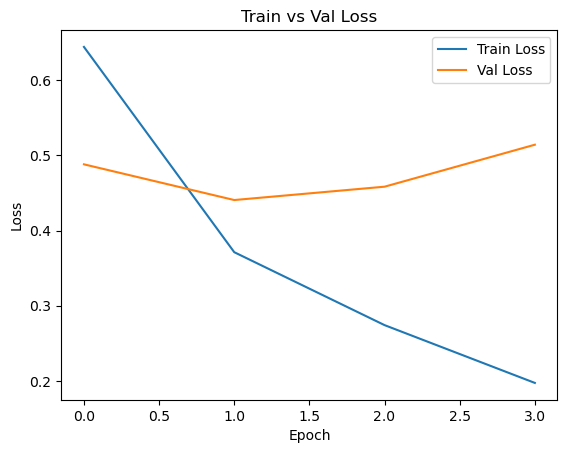

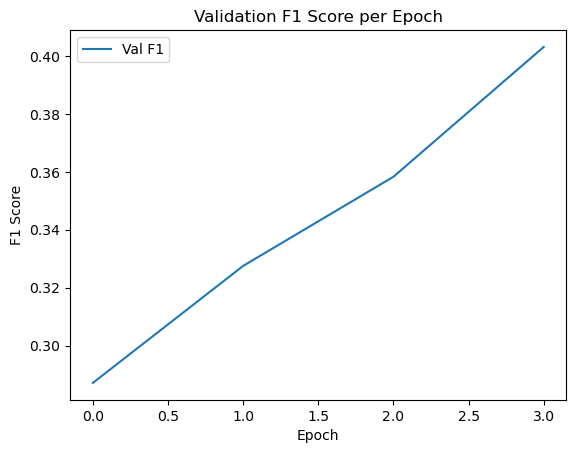

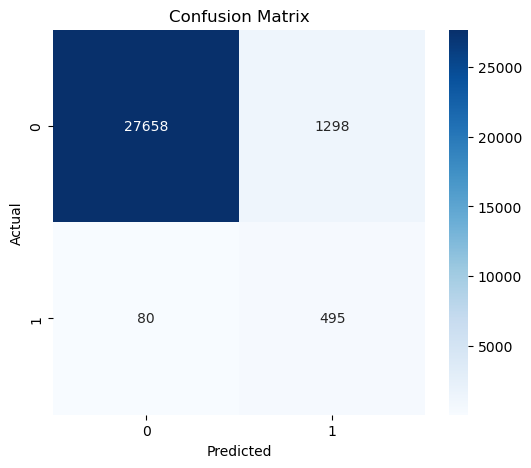

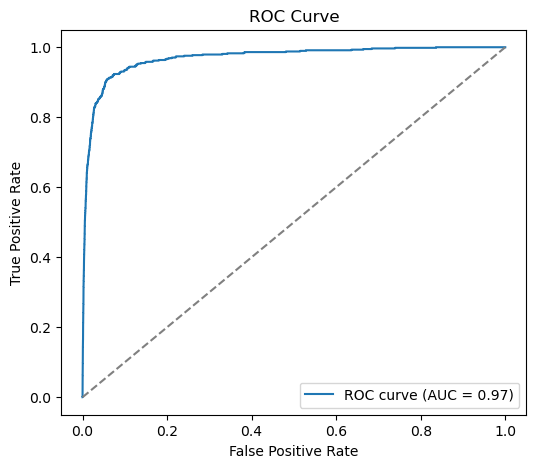

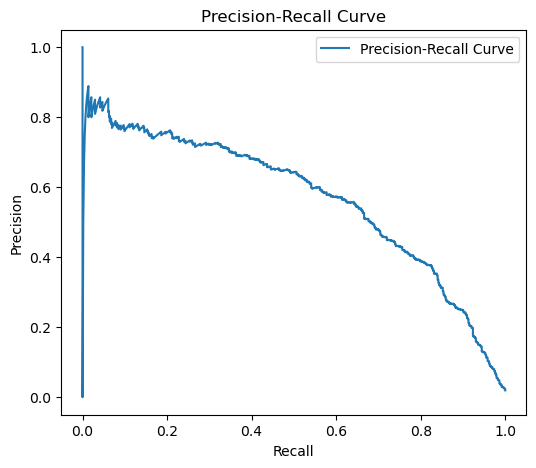


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     28956
         1.0       0.28      0.86      0.42       575

    accuracy                           0.95     29531
   macro avg       0.64      0.91      0.70     29531
weighted avg       0.98      0.95      0.96     29531



In [24]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report

# Plot train vs val loss
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.show()

# Plot val F1 score
plt.figure()
plt.plot(val_f1s, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score per Epoch")
plt.legend()
plt.show()

# Predict on test set for final visual evaluation
y_true, y_pred_classes, y_pred_probs = [], [], []
model.eval()
with torch.no_grad():
    for cat_padded, num_padded, labels_batch, lengths in test_loader:
        cat_padded = cat_padded.to(device)
        num_padded = num_padded.to(device)
        labels_batch = labels_batch.to(device)
        logits = model(cat_padded, num_padded, lengths)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        y_true.extend(labels_batch.cpu().numpy())
        y_pred_probs.extend(probs.cpu().numpy())
        y_pred_classes.extend(preds.cpu().numpy())

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, zero_division=0))